# Initial Study
To get a better grasp on the proper cycle of loan origination, I did some initial study before starting on the project. It is crucial to know where and at which stage of the process that this model is gonna be used, so that I know what are the informations can be obtained and feed into model as input. Upon research, the stages of loan origination as listed below:
1. Qualification process 
2. Loan Application
3. Loan Processing
4. Credit Decision
5. Underwriting Process
6. Quality Control
7. Loan Funding

**Assumption**:
- The loan risk prediction model should be used just before funding of the loan. This model can act as the last defense for the entire loan origination process, the output of this model can be used to aid in decision making.
- payment.csv data is excluded here, as this model is used to predict the risk of loan application, the payment data comes **AFTER** the loan is approved, and the client is repaying the loan, so it does not make sense to include payment data as input in this model.
- clarity_underwriting_variables.csv is an interesting data and could be very useful in this model, but the instructions in the PDF did not mentioned this dataset, so I restricted myself from using the other 2 datasets

# EDA

In [1]:
# importing dependencies
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# loading all data
loandf = pd.read_csv('./input/loan.csv')

In [3]:
loandf.head()

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1


In [4]:
loandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   loanId                            577426 non-null  object 
 1   anon_ssn                          577682 non-null  object 
 2   payFrequency                      576409 non-null  object 
 3   apr                               573760 non-null  float64
 4   applicationDate                   577682 non-null  object 
 5   originated                        577682 non-null  bool   
 6   originatedDate                    46044 non-null   object 
 7   nPaidOff                          577658 non-null  float64
 8   approved                          577682 non-null  bool   
 9   isFunded                          577682 non-null  int64  
 10  loanStatus                        577291 non-null  object 
 11  loanAmount                        575432 non-null  f

## Features screening
Before starting on any of the EDA, I first try to understand each and every features in the dataset, their data type, meaning and relevance towards the problem I am about to solve. I will note down any comments that I have and my expectations on specify features regarding their relevance to the problem. In this part, all my comments and analysis is purely based on my knowledge. Below are some of the features I find interesting.

- **payFrequency** a more frequent payment can have a lower overall loan interest, frequency also affect the convenience of client, higher frequency could mean clients have more cash on hand, high impact
- **apr**, **loanAmount**, **originallyScheduledPaymentAmount** the total loanAmount definitely affects the ability of client to repay the loan, medium impact
- **applicationDate** is the date of application for loan, low to none impact
- **nPaidOff** clients that have paid off loan in the past can indicate a very clean credit history, high impact
- **state** it is less likely that client's state has anything to do with its ability to pay off loan, but I do believe culture and education has its impact, low impact
- **LeadType** different lead type has gotten clients through different medium, some are hand-picked, some had been through strict identity verifications, it is safe to say clients that come from certain lead type are more credible, medium to impact
- **fpSatus** ignore payment data, none
- **originatedDate** ignore data, loan is originated when the whole process is completed, which is info that could not be obtained in practical world
- **LeadCost** most likely correlated with leadType variable, can be a redundant feature
- **loanStatus** target variable
- **hasCF** data indicating whether customer has clarityFraud records or not, don't have much information on this feature, I will let the model decide whether it is useful or not, impact undefined

In summary the features to focus on:
- payfrequency
- nPaidOff
- LeadType

Additional features can be generated:
- estimatedTotalLoanPayments (calcualted using apr, originallyScheduledPaymentAmount, payFequency, and loan amount)

This will be referred in the feature engineering step

## Analysis on target variable
Before I start working on any of the preprocessing and analysis on multiple different variable, it is usually better to start with the target variable. Since this is the model's output, this variable matter the most when it comes to model accuracy. Target variable is like a indicator that guide predictive model towards the right direction, if the direction is wrong, invalid, or inconsistent, the model's would not have a good performance.

In [5]:
loandf['loanStatus'].describe()

count                    577291
unique                       21
top       Withdrawn Application
freq                     450984
Name: loanStatus, dtype: object

I noticed that are only total of **577291** count, instead of **577682** which is the total row of the entire dataset, this indicate there are missing values.

This is a categortical data with 21 different classes, each of the different class need to be examine to ensure the target variable is what I needed.

In [6]:
loandf['loanStatus'].value_counts()

loanStatus
Withdrawn Application          450984
Rejected                        85070
Paid Off Loan                   11427
External Collection             11334
New Loan                         8112
Internal Collection              5567
Returned Item                    1182
CSR Voided New Loan              1026
Settlement Paid Off               708
Credit Return Void                704
Customer Voided New Loan          504
Settled Bankruptcy                326
Pending Paid Off                  169
Charged Off Paid Off              160
Pending Application Fee             5
Pending Rescind                     4
Pending Application                 4
Voided New Loan                     2
Charged Off                         1
Customver Voided New Loan           1
Settlement Pending Paid Off         1
Name: count, dtype: int64

<Axes: xlabel='Count', ylabel='loanStatus'>

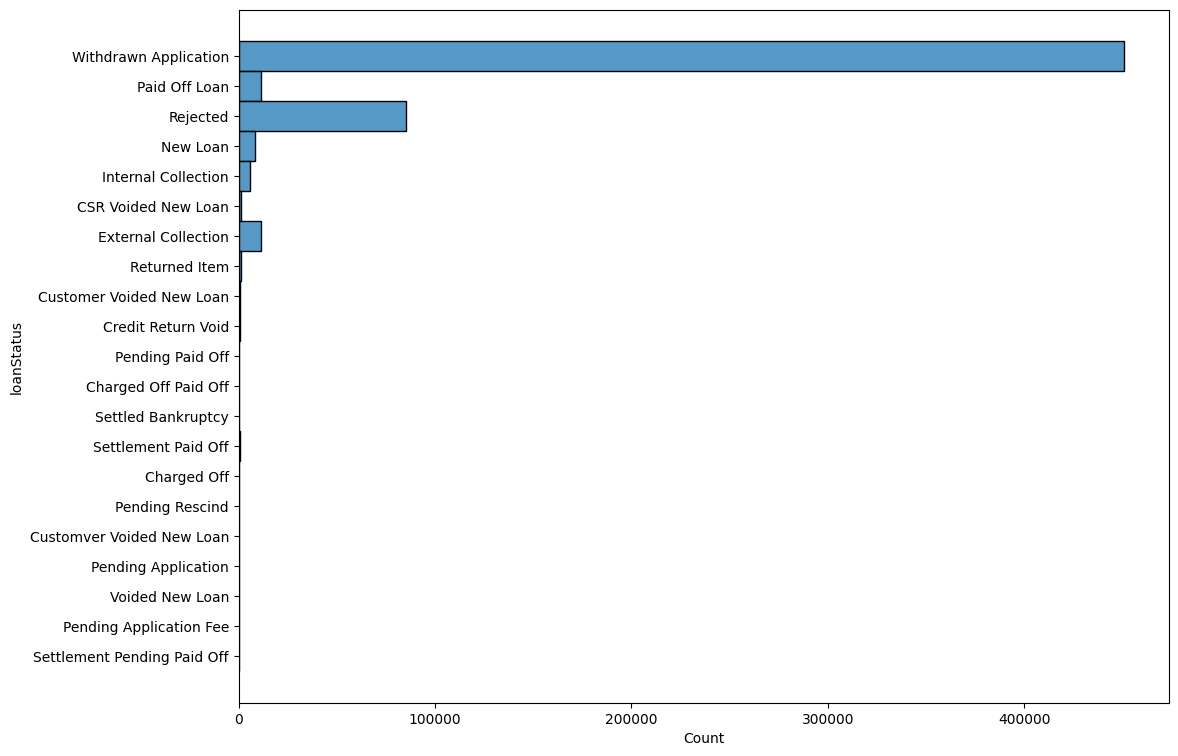

In [7]:
fg, ax = plt.subplots(figsize=(12, 9))
sns.histplot(y=loandf['loanStatus'])

The classes in loan status is HIGHLY imbalance, before I deal with that, I first did some feature engineering on the target variable to only take what is needed for the model.
***
I have decided to group the loan statuses into 2 categories to cater to the model's needs.

- **0 - Low Risk**
- **1 - High Risk**

I took some time to search some of the jargons of all the statuses, I grouped them based on my own understanding of its risk.

***
Summaries from the loan statuses:
- **Withdrawn Application**, I have decided to drop all data with this status, these are all the applications that have been canceled by either client or human underwriters. (This data takes up like 70 to 80% of the entire dataset so I was hesitant to throw it away, but I cant seems to think of any relevance of this data in contributing to the prediction model)
- **Status With "Void"**, all are dropped, since the loan is canceled
- **Paid Off** / **Pending Paid Off**, Both are classified as **Low Risk**
- **Returned Item**, this data will be classified as low risk, missing only one payment is acceptable, classified as **Low Risk**
- **Settlement Paid Off** / **Settlement Pending Paid Off**, Loan that paid through settlement might not be the ideal case, but at least client is willing to paid it off through settlement, instead of letting the loan charged off, classified as **Low Risk**
- **External/Internal Collection**, this happens when clients start missing payments, company need extra efforts and resources to chase back the loan, classified as **High Risk**
- **Settled Bankruptcy**, is classified as **High Risk**, A client who is at risk of declaring bankruptcy should always flagged as High Risk, since it is uncertain of repayment.
- **Charged Off / Charged Off Paid Off**, both are classified as **High Risk**
- **New Loan**, data is dropped, not enough information to classify them as high or low risk
- **Rejected**, data is dropped, there could be many possibilities that loan application is rejected, some are due to loan amount, incomplete application, failed to meet criteria, etc. Due to there are various reasons, this data is not used.

In [8]:
# map status 
statusMap = {
    "Charged Off": 1, "Charged Off Paid Off": 1, "Settled Bankruptcy": 1, "External Collection": 1, "Internal Collection": 1,
    "Returned Item": 0, "Settlement Paid Off": 0, "Settlement Pending Paid Off": 0, "Paid Off Loan": 0, "Pending Paid Off": 0
    }
loandf['loanStatus'] = loandf['loanStatus'].map(statusMap)

# drop other loan status data, this include dropping the missing values discovered above
loandf.drop(loandf[loandf['loanStatus'].isna()].index, inplace=True)


print(f"Missing values in loan status: {loandf['loanStatus'].isna().sum()} \n")

print(loandf['loanStatus'].value_counts())

Missing values in loan status: 0 

loanStatus
1.0    17388
0.0    13487
Name: count, dtype: int64


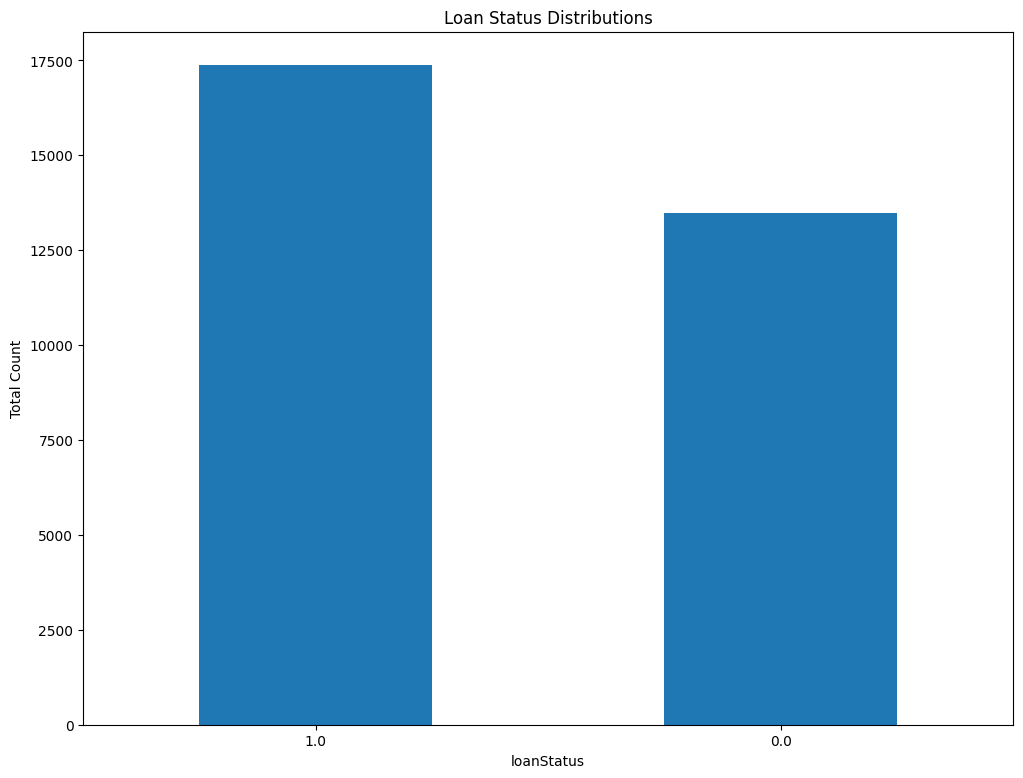

High Risk class: 56.32%
Low Risk class: 43.68%


In [9]:
fg, ax = plt.subplots(figsize=(12, 9))
ax.set(title= 'Loan Status Distributions', ylabel= 'Total Count',  xlabel= 'Loan Status')
loandf['loanStatus'].value_counts().plot.bar(rot=0)
plt.show()
print(f"High Risk class: {loandf['loanStatus'].value_counts()[1] / loandf.shape[0] * 100 :.2f}%")
print(f"Low Risk class: {loandf['loanStatus'].value_counts()[0] / loandf.shape[0] * 100 :.2f}%")

The loan status variable is now much balanced, we can work with target classes ratio distributions of 56% to 43%

## Splitting Dataset
Ideally the best time to split the train and test set is before any sort of numerical transformation is conducted. Splitting dataset at the very first step prevents data leakage, to really test model with some unseen data. But for the sake of simplicity, some target variables analysis are conducted before splitting. Splitting the data here before the data preprocessing, and transformation to prevent further data leakage.

In [10]:
trainx, testx, trainy, testy = train_test_split(
    loandf.drop(['loanStatus'], axis=1), 
    loandf['loanStatus'], 
    test_size=0.2,
    random_state=88)

In [11]:
trainx.shape

(24700, 18)

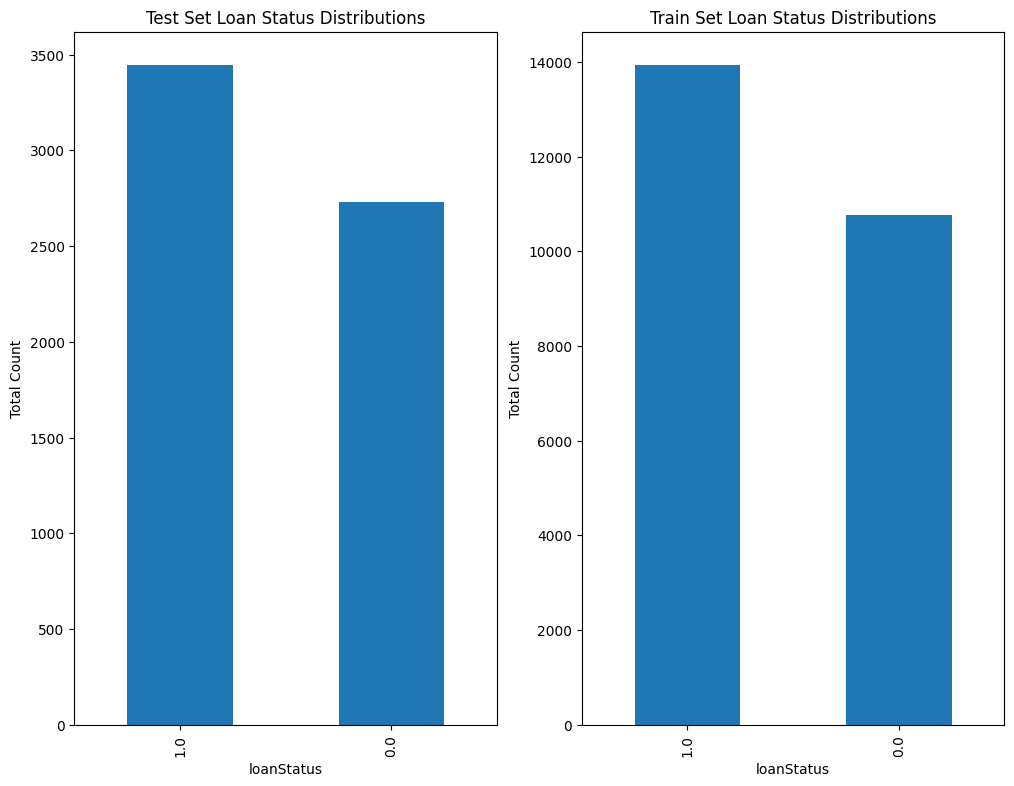

In [12]:
# check the distributions
fg, ax = plt.subplots(1, 2, figsize=(12,9))

ax[0].set(title= 'Test Set Loan Status Distributions', ylabel= 'Total Count',  xlabel= 'Loan Status')
pd.DataFrame(testy)['loanStatus'].value_counts().plot.bar(ax= ax[0])

ax[1].set(title= 'Train Set Loan Status Distributions', ylabel= 'Total Count',  xlabel= 'Loan Status')
pd.DataFrame(trainy)['loanStatus'].value_counts().plot.bar(ax=ax[1])
plt.show()

## Data Pre-processing
After making sure the target variable had been properly handled, the overall data seems much more promising to be used for training the model. With that in mind, preprocessing of other data is pretty straightforwards.

***
If feature screening and target variable analysis was not conducted before this step, many time could be wasted on preprocessing data that might not be helpful at the end.

### Missing Values
In this stage, data imputation is conducted to handle missing values

In [13]:
# find out missing data
numOfMissing = trainx.isnull().sum().sort_values(ascending=False)
percentageOfMissing = (trainx.isnull().sum()/trainx.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([numOfMissing, percentageOfMissing], axis=1, keys=['Total Missing', 'Missing Percentage'])
missing_data.head(20)

,Total Missing,Missing Percentage
clarityFraudId,4127,0.167085
nPaidOff,20,0.000810
fpStatus,11,0.000445
originatedDate,4,0.000162
payFrequency,1,0.000040
loanId,0,0.000000
originallyScheduledPaymentAmount,0,0.000000
leadCost,0,0.000000
leadType,0,0.000000
state,0,0.000000


Missing data need to be analysed before deciding on which technique to handle the missing data. Usually the rule of thumb is that if the missing data is consists of more than 15% of the total data, the column should be dropped. It is hard to "assume" or "estimate" the missing data's value when the total missing data is more than 15% of total data. In this case, all missing data are lesser than 15% of total rows of data, except for **clarityFraudId**, which is not needed for in this prediction model.

Summaries:

- **clarityFraudId** entire column will be dropped, since the other 2 datasets are not allowed to use, this column have no use
- **fpStatus** entire column will be dropped as well, since it is an information about payment, this information cannot be obtained in practical use
- **payFrequency** missing values will be replace with the mode value, since it is unlikely to estimate this value, using the majority value should do just fine
- **nPaidOff** missing values will be replace with the mean value rounded up according to its loan status, since this is one of the variable I think might have high impact on the model, a more accurate estimation approach is taken

In [14]:
# dropping column
trainx.drop(['clarityFraudId', 'fpStatus'], axis=1, inplace=True)
testx.drop(['clarityFraudId', 'fpStatus'], axis=1, inplace=True)

In [15]:
# replace payfrequency with mode value
trainx['payFrequency'].fillna(trainx['payFrequency'].mode()[0], inplace=True)
testx['payFrequency'].fillna(testx['payFrequency'].mode()[0], inplace=True)

In [16]:
# fix missing values for nPaidOff

# train set 
lowM = trainx.loc[trainy == 0, 'nPaidOff'].mean()
highM = trainx.loc[trainy == 1, 'nPaidOff'].mean()
print(f"mean of nPaidOff for low risk: {lowM}, rounded up: {round(lowM)}")
print(f"mean of nPaidOff for high risk: {highM}, rounded up: {round(highM)}")
trainx.loc[(trainy == 0) & (trainx['nPaidOff'].isnull()), 'nPaidOff'] = round(lowM)
trainx.loc[(trainy == 1) & (trainx['nPaidOff'].isnull()), 'nPaidOff'] = round(highM)

# test set 
lowM = testx.loc[testy == 0, 'nPaidOff'].mean()
highM = testx.loc[testy == 1, 'nPaidOff'].mean()
testx.loc[(testy == 0) & (testx['nPaidOff'].isnull()), 'nPaidOff'] = round(lowM)
testx.loc[(testy == 1) & (testx['nPaidOff'].isnull()), 'nPaidOff'] = round(highM)

mean of nPaidOff for low risk: 0.5692364921417279, rounded up: 1
mean of nPaidOff for high risk: 0.17211172542543263, rounded up: 0


In [17]:
trainx.isna().sum().sort_values(ascending=False)

originatedDate                      4
loanId                              0
anon_ssn                            0
payFrequency                        0
apr                                 0
applicationDate                     0
originated                          0
nPaidOff                            0
approved                            0
isFunded                            0
loanAmount                          0
originallyScheduledPaymentAmount    0
state                               0
leadType                            0
leadCost                            0
hasCF                               0
dtype: int64

In [18]:
testx.isna().sum().sort_values(ascending=False)

originatedDate                      1
loanId                              0
anon_ssn                            0
payFrequency                        0
apr                                 0
applicationDate                     0
originated                          0
nPaidOff                            0
approved                            0
isFunded                            0
loanAmount                          0
originallyScheduledPaymentAmount    0
state                               0
leadType                            0
leadCost                            0
hasCF                               0
dtype: int64

### Outliers

Missing values are not the only thing causing a data "dirty", the outliers must be addressed as well. Outliers have significant impact on the performance of machine learning model, especially models like linear regression. Outliers usually happened due to external errors like human error during data entry, or system invalid outputs. 

In this stage, simple analysis is conducted to detect outliers and handle them, if there is any

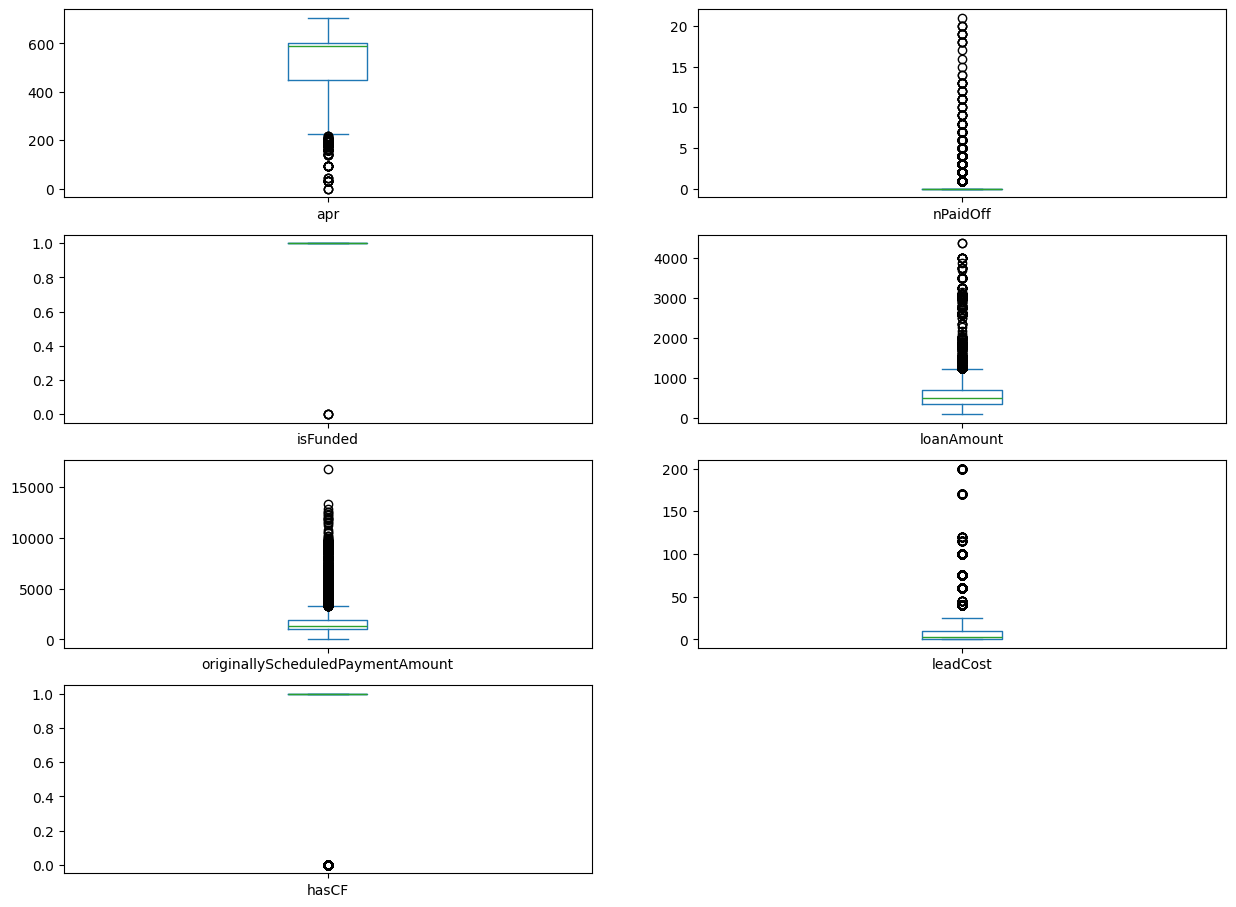

In [19]:
trainx.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

From the boxplot above, there isn't any obvious outliers, beside that one data point that has more than 15000 originallyScheduledPaymentAmount. So I take a look at the data.

In [20]:
trainx[trainx['originallyScheduledPaymentAmount'] > 15000]

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,hasCF
231082,LL-I-16306269,9781eeabf39894223bfbb55ca33f7feb,S,240.0,2017-01-27T01:11:22.984000,True,2017-01-27T01:30:10.509000,0.0,True,1,3500.0,16800.12,GA,lead,25,1


To conclude, none of the data point are considered as an outlier at the moment, but the specific data with more than 15000 originallyScheduledPaymentAmount is noted down.

### Data Transformation

This stage involve the transforming the data into the desire format. In term of dealing with machine learning model, all the data needs to be in numerical format, therefore this stage involves activities like converting categorical data into numerical value and etc.

In [21]:
trainx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24700 entries, 498356 to 496150
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   loanId                            24700 non-null  object 
 1   anon_ssn                          24700 non-null  object 
 2   payFrequency                      24700 non-null  object 
 3   apr                               24700 non-null  float64
 4   applicationDate                   24700 non-null  object 
 5   originated                        24700 non-null  bool   
 6   originatedDate                    24696 non-null  object 
 7   nPaidOff                          24700 non-null  float64
 8   approved                          24700 non-null  bool   
 9   isFunded                          24700 non-null  int64  
 10  loanAmount                        24700 non-null  float64
 11  originallyScheduledPaymentAmount  24700 non-null  float64
 12  sta

In [22]:
# Ordinal encoding and One-hot encoding
# pay frequency is an ordinal features, using one hot encoding will result in information loss
# higher value indicate higher frequency, vice versa
mapPayFrequency = {
    "W": 4,
    "B": 3,
    "S": 2,
    "M": 1,
    "I": 0
}
# train
trainx['payFrequency'] = trainx['payFrequency'].map(mapPayFrequency)

# test
testx['payFrequency'] = testx['payFrequency'].map(mapPayFrequency)

In [23]:
# One-hot encoding on both state and leadType columns
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# train
encoded = enc.fit_transform(trainx[['state', 'leadType']])
encodedDf = pd.DataFrame(encoded, columns=enc.get_feature_names_out(), index=trainx.index)
trainx = pd.concat([trainx, encodedDf], axis=1)

# test
testencoded = enc.transform(testx[['state', 'leadType']])
testencodedDf = pd.DataFrame(testencoded, columns=enc.get_feature_names_out(), index=testx.index)
testx = pd.concat([testx, testencodedDf], axis=1)

In [24]:
enc.categories_

[array(['AK', 'AL', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA',
        'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MD', 'MI', 'MN', 'MO', 'MS',
        'NC', 'ND', 'NE', 'NJ', 'NM', 'NV', 'OH', 'OK', 'PA', 'RI', 'SC',
        'SD', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WY'], dtype=object),
 array(['bvMandatory', 'california', 'express', 'instant-offer', 'lead',
        'lionpay', 'organic', 'prescreen', 'rc_returning', 'repeat'],
       dtype=object)]

In [25]:
# deal with date objects
# application date will be split into 3 categories, the days, months, and year
trainx['application_day'] = pd.to_datetime(trainx['applicationDate'], format="mixed").dt.day
trainx['application_month'] = pd.to_datetime(trainx['applicationDate'], format="mixed").dt.month
trainx['application_year'] = pd.to_datetime(trainx['applicationDate'], format="mixed").dt.year


testx['application_day'] = pd.to_datetime(testx['applicationDate'], format="mixed").dt.day
testx['application_month'] = pd.to_datetime(testx['applicationDate'], format="mixed").dt.month
testx['application_year'] = pd.to_datetime(testx['applicationDate'], format="mixed").dt.year

### Analysis Features on Target Relation

When there are a lot of features in the dataset, it is hard to conduct feature engineering when you have no idea on how correlated the features are to the target variables. Conducting this relation analysis can help eliminating features that are less correlated, it also helps decide on which features to engineer.

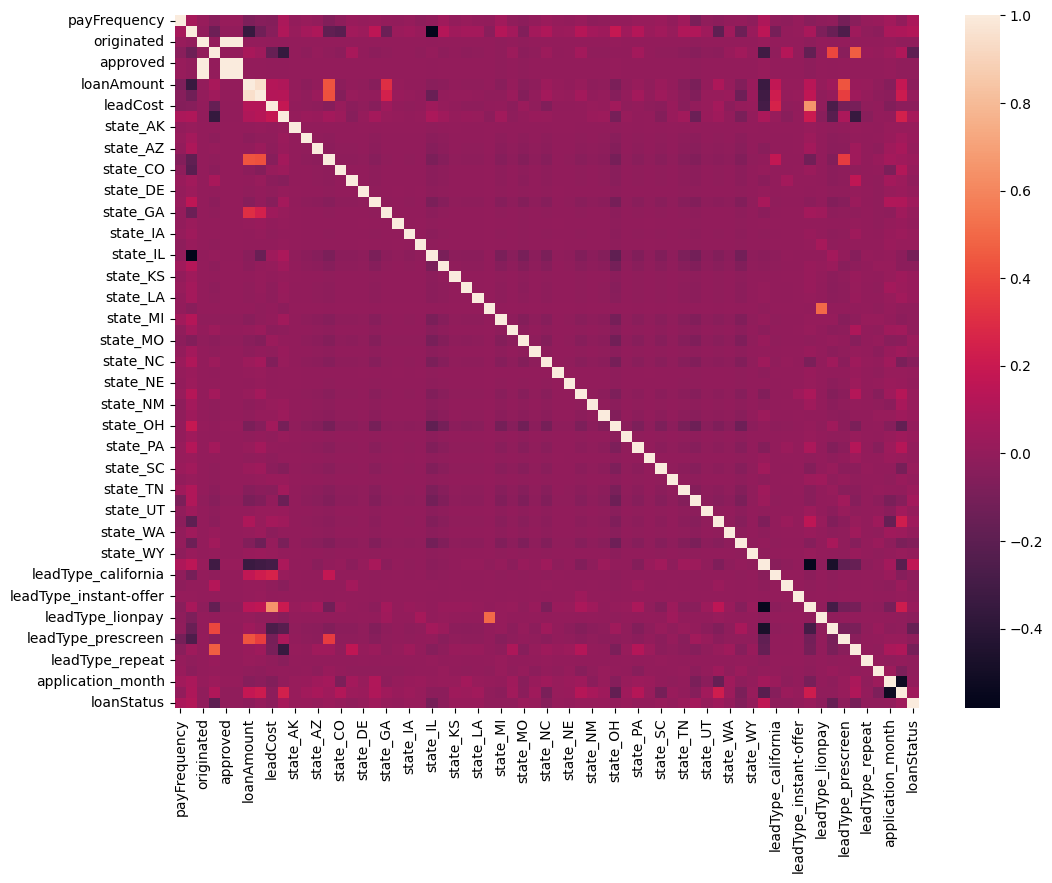

In [26]:
alldata = pd.concat([trainx, trainy], axis=1)
corrData = alldata.loc[:, alldata.dtypes != "object"].corr()
fg, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrData)
plt.show()

In [27]:
abs(corrData['loanStatus']).sort_values(ascending=False)[:20]

loanStatus               1.000000
nPaidOff                 0.193231
leadType_organic         0.162018
leadType_bvMandatory     0.159699
apr                      0.115393
leadType_rc_returning    0.101905
state_IL                 0.101844
payFrequency             0.083285
hasCF                    0.069456
state_TX                 0.058377
state_WI                 0.057575
state_FL                 0.045914
application_year         0.042508
state_NC                 0.040404
state_VA                 0.037555
state_TN                 0.028772
state_CA                 0.026190
state_IN                 0.024800
leadCost                 0.024151
state_MO                 0.023926
Name: loanStatus, dtype: float64

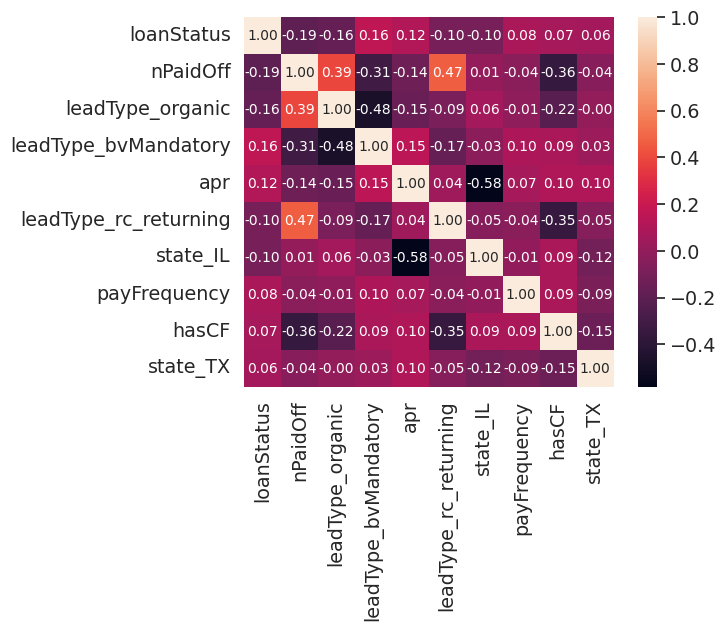

In [28]:
# top 10 loan status correlation matrix
cols = abs(corrData['loanStatus']).sort_values(ascending=False)[:10].index
cm = np.corrcoef(alldata[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

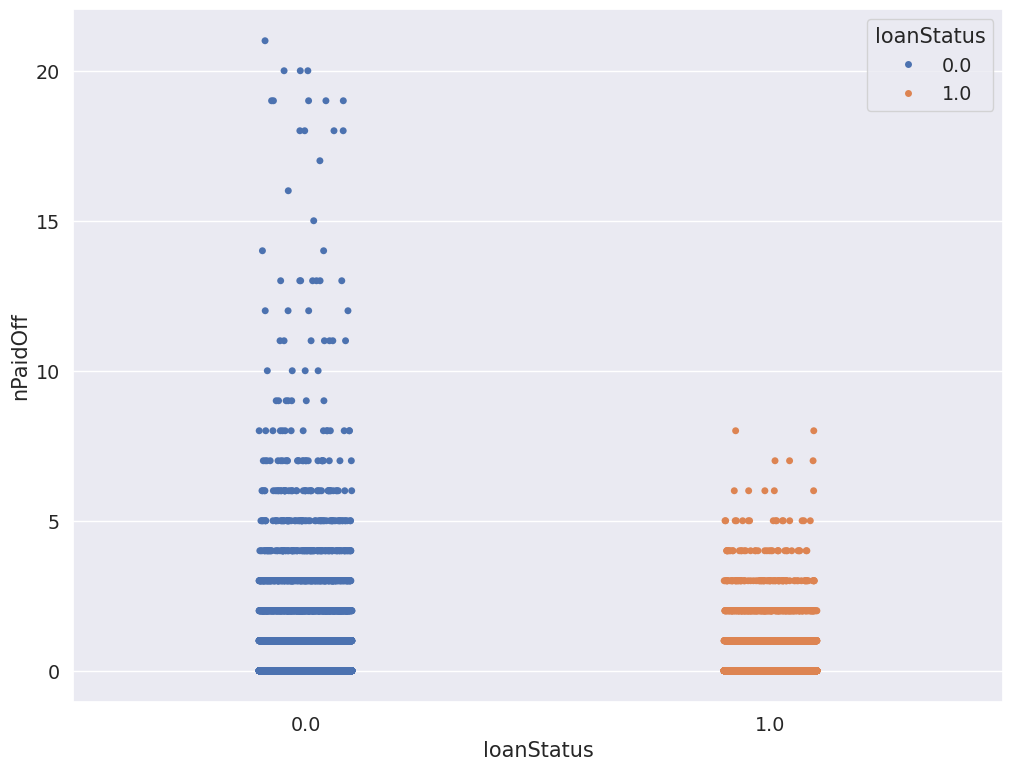

In [29]:
fg, ax = plt.subplots(figsize=(12, 9))
sns.stripplot(y=trainx['nPaidOff'], x=trainy, hue=trainy)
plt.show()

From the diagram above, what can be certain of is that clients that have more than 10 previous loan paid off to company has chance of slim to none of not replaying back the loan. The relation between the risk of loan and nPaidOff is that the more the loan client had paid off in the past, the lower the risk. This prove my hypothesis.

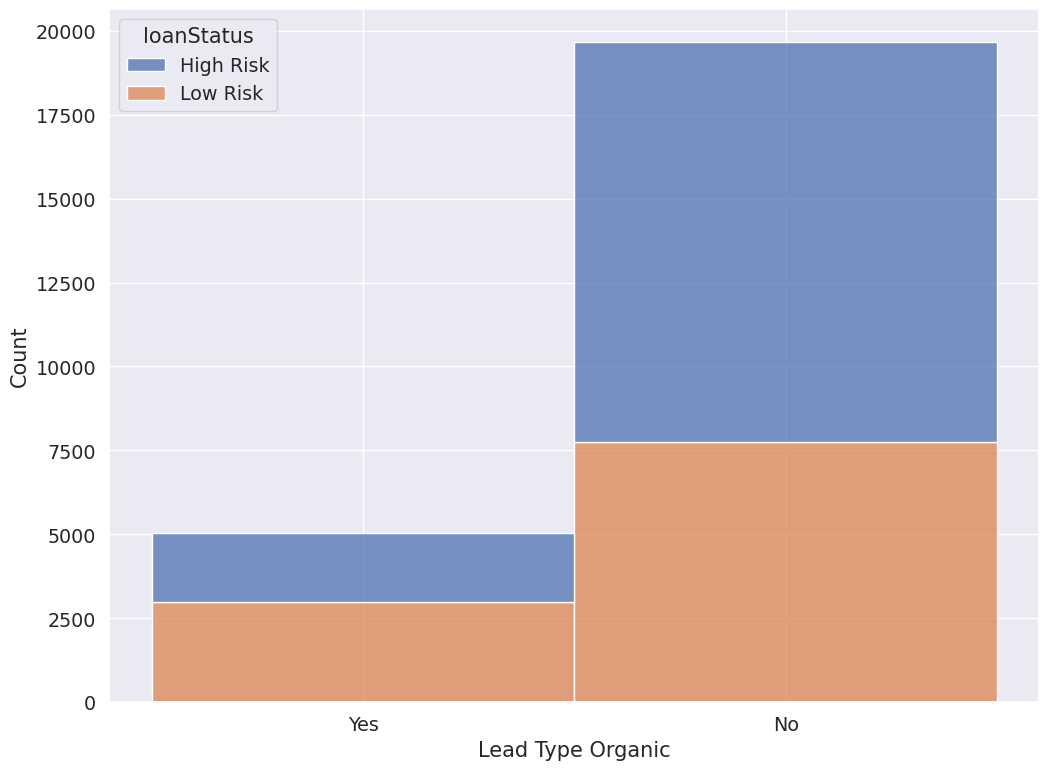

In [30]:
fg, ax = plt.subplots(figsize=(12, 9))
temp = pd.Categorical(trainx['leadType_organic'].map({1: "Yes", 0: "No"}), ['Yes', 'No'])
ax.set_xlabel("Lead Type Organic")
sns.histplot(
    x=temp,
    hue=trainy.map({1: "High Risk", 0: "Low Risk"}) , multiple="stack")
plt.show()

From the diagram above, clients that come from company's website by itself have a lower risk. This can be due to people that come from the website are actually people that wants to loan, not someone that is being persuaded into one.

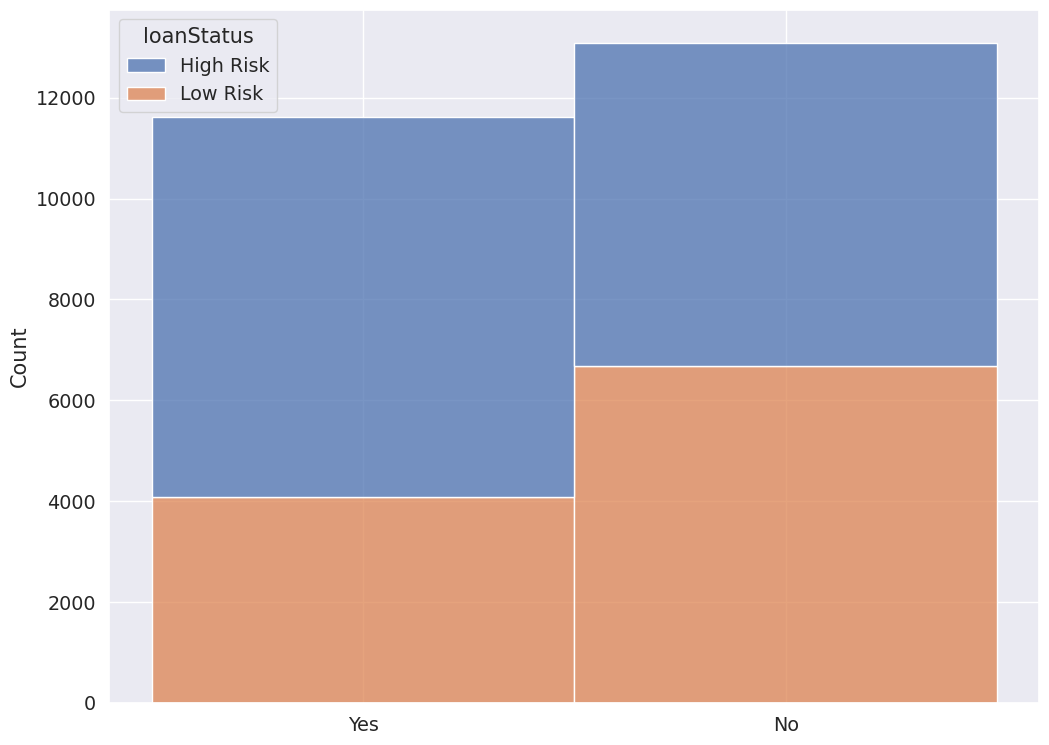

In [31]:
fg, ax = plt.subplots(figsize=(12, 9))
temp = pd.Categorical(trainx['leadType_bvMandatory'].map({1: "Yes", 0: "No"}), ['Yes', 'No'])
sns.histplot(
    x=temp, 
    hue=trainy.map({1: "High Risk", 0: "Low Risk"}) , multiple="stack")
plt.show()

Surprisingly, clients that come through ping tree which require bank verifications is actually higher risk of not repaying back the loan.

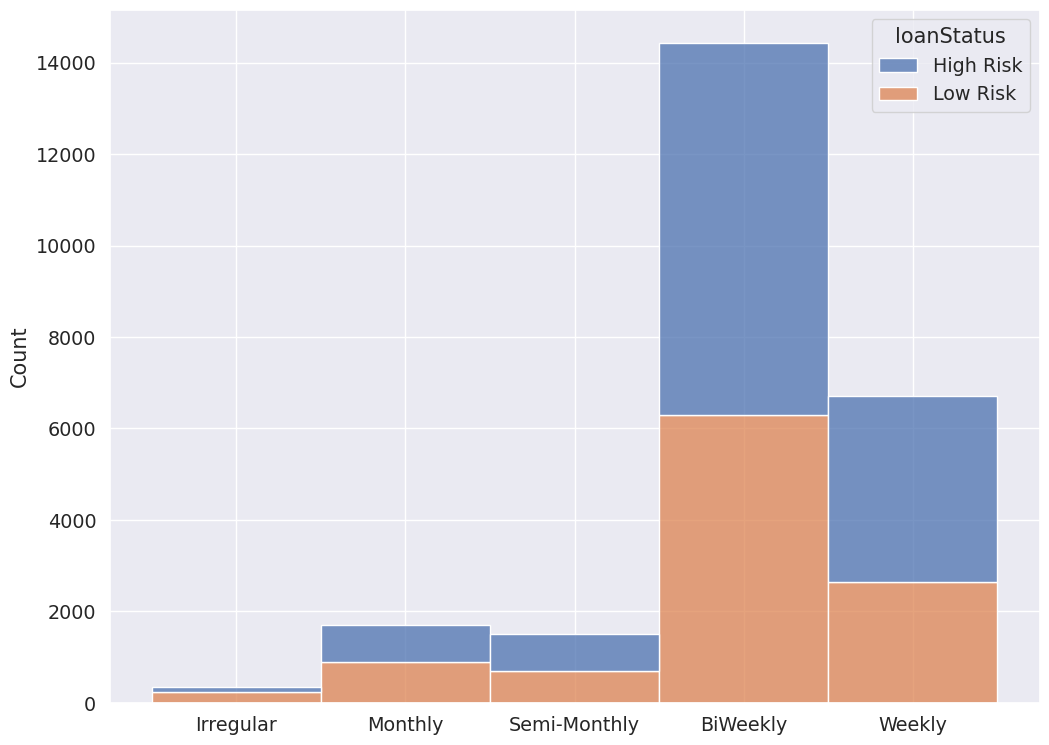

In [32]:
fg, ax = plt.subplots(figsize=(12, 9))
temp = pd.Categorical(
    trainx['payFrequency'].map({0: "Irregular", 1: "Monthly", 2: "Semi-Monthly", 3: "BiWeekly", 4: "Weekly"}),
    ['Irregular', 'Monthly', 'Semi-Monthly', 'BiWeekly', 'Weekly'])
sns.histplot(
    x=temp, 
    hue=trainy.map({1: "High Risk", 0: "Low Risk"}) , multiple="stack")
plt.show()

From bar chart above, the relationship between these 2 data is not significant, the more frequent the repayment schedule, the higher the risk. This information contradicts with my initial assumption, as I thought repayment schedule will have a high impact on the risk of loan.

## Feature engineering
Features to be used in the model are extracted, or generated in this stage.

In [33]:
trainx.drop([
    'loanId',
    'anon_ssn', 
    'applicationDate', 
    'originated', 
    'originatedDate', 
    'state', 
    'leadType',
    'approved',
    'isFunded'
], axis=1, inplace=True)


testx.drop([
    'loanId',
    'anon_ssn', 
    'applicationDate', 
    'originated', 
    'originatedDate', 
    'state', 
    'leadType',
    'approved',
    'isFunded'
], axis=1, inplace=True)

trainx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24700 entries, 498356 to 496150
Data columns (total 61 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   payFrequency                      24700 non-null  int64  
 1   apr                               24700 non-null  float64
 2   nPaidOff                          24700 non-null  float64
 3   loanAmount                        24700 non-null  float64
 4   originallyScheduledPaymentAmount  24700 non-null  float64
 5   leadCost                          24700 non-null  int64  
 6   hasCF                             24700 non-null  int64  
 7   state_AK                          24700 non-null  float64
 8   state_AL                          24700 non-null  float64
 9   state_AZ                          24700 non-null  float64
 10  state_CA                          24700 non-null  float64
 11  state_CO                          24700 non-null  float64
 12  sta

As mentioned during the feature screening stage, one additional feature to be generated is the loanTotalPayments, this features takes payFrequency, originallySCheduledAmount, loanAmount, and apr to calculate. Note: the generated feature might not be the exact number of payments for this loan, but this information might be useful for model to discover any patterns behind.

In [34]:
def estimateTotalPayments(apr, loanAmount, payFrequency, originallyScheduledAmount):
    # prevent invalid input
    if apr == 0 :
        return 0

    # Convert apr to periodic interest rate based on pay frequency
    if payFrequency == 1:
        r = apr / 12 / 100
    elif payFrequency == 2:
        r = apr / 24 / 100
    elif payFrequency == 3:
        r = apr / 26 / 100
    elif payFrequency == 4:
        r = apr / 52 / 100
    else: 
#         duration on irregularly scheduled
        return 0

    n = originallyScheduledAmount / (r * loanAmount)

    return round(n)

trainx['estimateLoanPaymentsNum'] = trainx.apply(
    lambda x: estimateTotalPayments(
        x['apr'],
        x['loanAmount'], 
        x['payFrequency'],
        x['originallyScheduledPaymentAmount']
    ), axis=1)

testx['estimateLoanPaymentsNum'] = testx.apply(
    lambda x: estimateTotalPayments(
        x['apr'],
        x['loanAmount'], 
        x['payFrequency'],
        x['originallyScheduledPaymentAmount']
    ), axis=1)

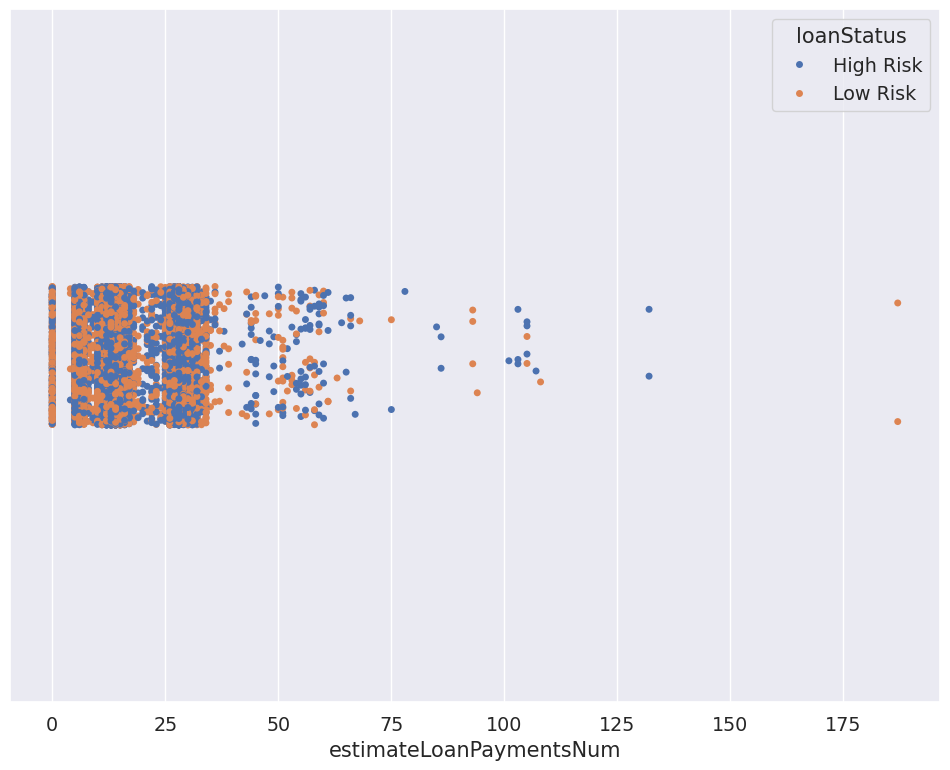

In [35]:
fg, ax = plt.subplots(figsize=(12, 9))
sns.stripplot(x=trainx['estimateLoanPaymentsNum'], 
                hue=trainy.map({1: "High Risk", 0: "Low Risk"}))
plt.show()

Most of the total loan payments happened around 0 to 30. But I don't see clear relation between loan status and total loan payments.

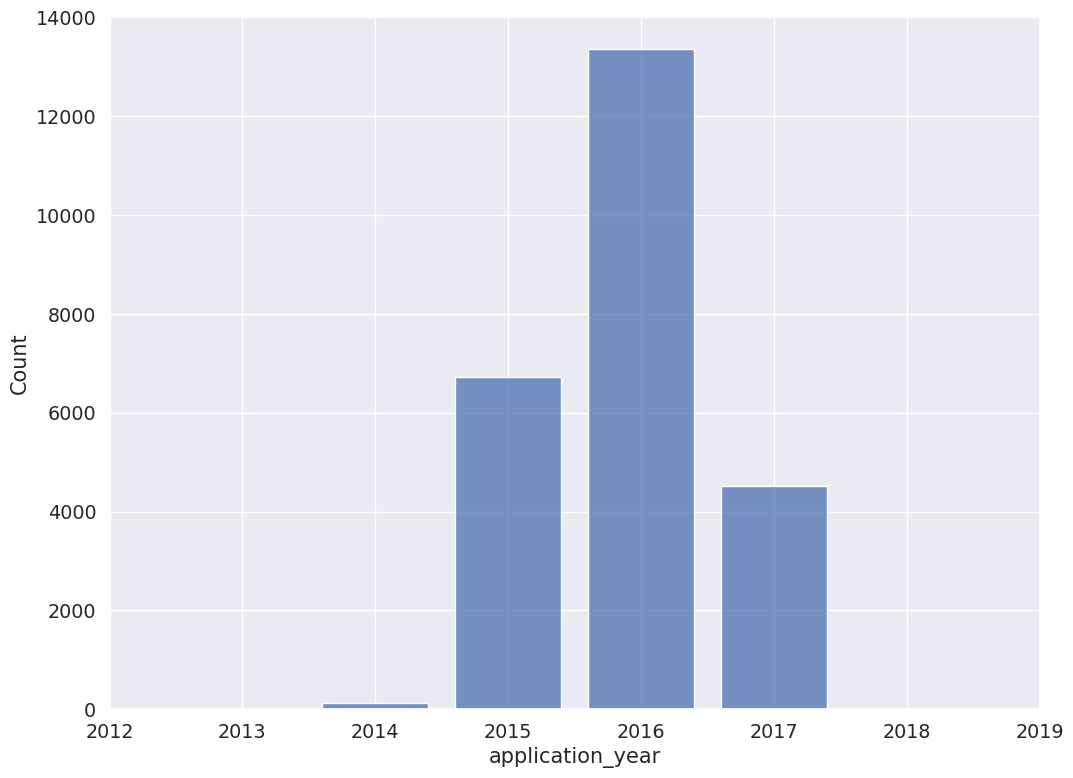

In [36]:
fg, ax = plt.subplots(figsize=(12, 9))
sns.histplot(x=trainx['application_year'], discrete=True, shrink=0.8)
plt.xticks(list(range(2012, 2020, 1)))
plt.show()

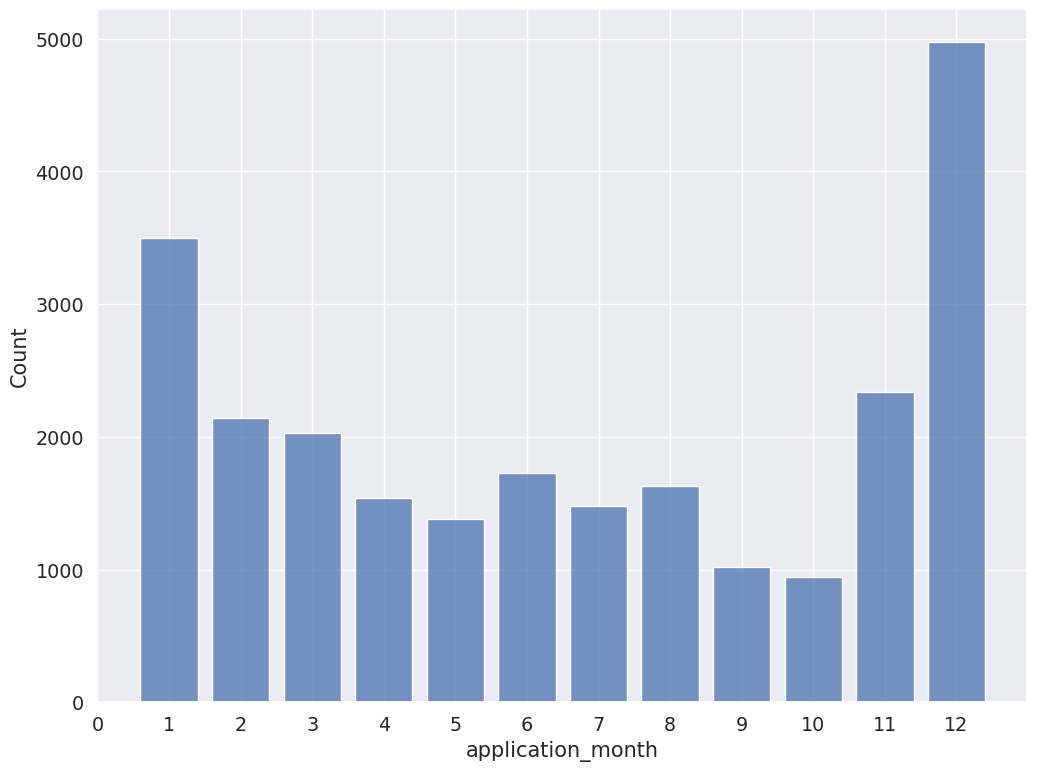

In [37]:
fg, ax = plt.subplots(figsize=(12, 9))
sns.histplot(x=trainx['application_month'], discrete=True, shrink=0.8)
plt.xticks(list(range(0, 13, 1)))
plt.show()

## Feature scaling

Usually this stage consists of scaling the features and target variables to achieve normality. A normally distributed data helps with better training speed as well as the model's performance.
But in this case, lightGBM **DOES NOT** require feature scaling, since it is a decision tree model, which they learn by splitting different nodes, so features that are not scaled would not affect its performance. Therefore, this stage is ignored.

# Training of Model

Finally, after all the analysis and preprocessing, this is the stage where we finally get to fed the data into a model.

In [38]:
model = lgb.LGBMClassifier(n_estimators = 200, num_leaves=30)
model.fit(trainx, trainy)

[LightGBM] [Info] Number of positive: 13941, number of negative: 10759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 24700, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.564413 -> initscore=0.259092
[LightGBM] [Info] Start training from score 0.259092


LGBMClassifier(n_estimators=200, num_leaves=30)

In [39]:
pred_train_y = model.predict(trainx)
pred_test_y = model.predict(testx)

In [40]:
print('LightGBM Model accuracy train score: {0:0.4f}'.format(accuracy_score(pred_train_y, trainy)))
print('LightGBM Model accuracy test score: {0:0.4f}'.format(accuracy_score(pred_test_y, testy)))

LightGBM Model accuracy train score: 0.7209
LightGBM Model accuracy test score: 0.6460


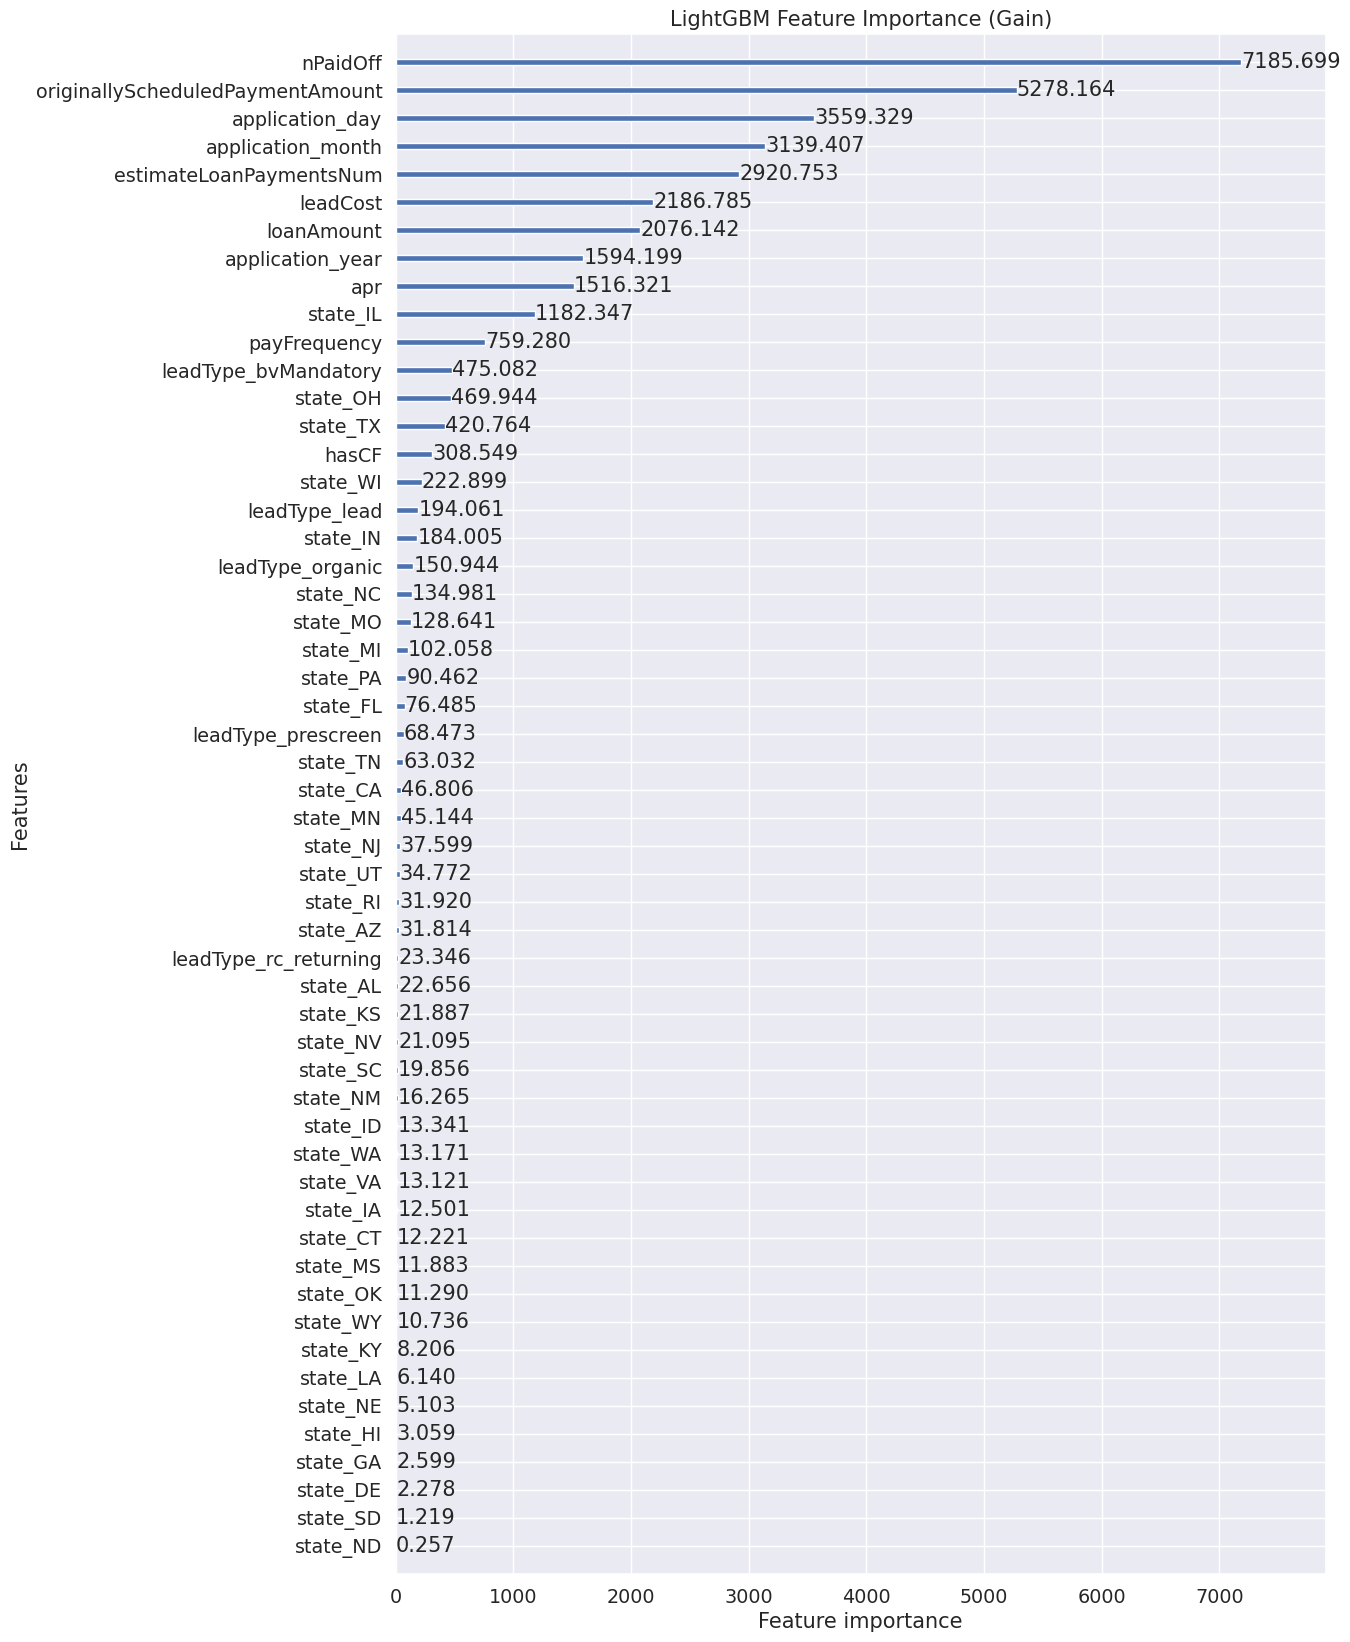

In [41]:
lgb.plot_importance(model, importance_type="gain", figsize=(12,20), title="LightGBM Feature Importance (Gain)")
plt.show()

Summaries:
- There is no surprise that the **nPaidOff** being ranked as the most important feature.
- **originallyScheduledPaymentAmount** and **loanAmount** being in the top 10 also proven my initial assumption to be correct
- The importance of 3 of the application date features **applicationDay** **applicationMonth** and **applicationYear** surprised me, it might have something to do with the financial crisis happened during that timeframe
- The new generated **estimateLoanPaymentsNum** feature seems to be working well, ranked top 5 on the importance of features

# Model Evaluation

Evaluate the model developed, how good it performed on both training data and test data.

In [42]:
# confusion matrix is best used for evaluating a classifier model 

cm = confusion_matrix(testy, pred_test_y)
print('Confusion matrix\n\n', cm)
print('True Positives(TP) = ', cm[0,0])
print('True Negatives(TN) = ', cm[1,1])
print('False Positives(FP) = ', cm[0,1])
print('False Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1374 1354]
 [ 832 2615]]
True Positives(TP) =  1374
True Negatives(TN) =  2615
False Positives(FP) =  1354
False Negatives(FN) =  832


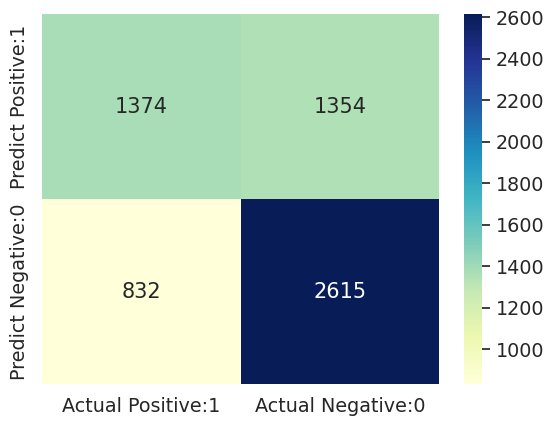

In [43]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [44]:
print(classification_report(testy, pred_test_y))

              precision    recall  f1-score   support

         0.0       0.62      0.50      0.56      2728
         1.0       0.66      0.76      0.71      3447

    accuracy                           0.65      6175
   macro avg       0.64      0.63      0.63      6175
weighted avg       0.64      0.65      0.64      6175



In best case scenario, we would want both the recall and precision to be as high as possible, however there is trade-off between recall and precision. Therefore it leaves to the engineer to choose which metrics they value more. In this case of predicting loan risk, having a **high recall** score is more valued than precision.

# Conclusion

In this Jupyter Notebook, we explored the problem in predicting loan risk. We performed EDA on loan.csv file to gain insights on which features to aid in predicting loan risk. It's important to note that solely using loan information would not be enough to develop an accurate predictive model, even though it is doable but using more features on client's profile should yield a better predictive model. 

## Potential Improvement:
- The use of client's historical payment data can give us and the model a better understanding of the client's credit score
- The clarity_underwriting csv file seems to have a score given by the underwriter, it should be helping the model assess the risk of the client
- Merely using loan information to predict loan risk is not enough instead, information regarding the client's profile is much more important in this case. For example: client's age, income, credit score


Total time spent around 20 hours